In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import numpy as np

# Import libraries for running ANOVA and post-hoc test
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg

#for fetching repositories from the UC Irvine Machine Learning Repository
from ucimlrepo import fetch_ucirepo 

# Import Data

* Read files
* Create a mapping table of countries in both tables
* Copy income column to world bank data


In [3]:
# Read the World Bank development indicators dataset

worldbank_path = "../additional_material/week_05_world_bank_development_indicators.csv"
worldbank = pd.read_csv(worldbank_path)

# Read the income dataset (Excel file)
income_path = "../additional_material/week_05_income.xlsx"
income = pd.read_excel(income_path)

# Show the first rows of each dataset to confirm that everything loaded correctly
print("World Bank indicators dataset:")
print(worldbank.head())

print("\nIncome dataset:")
print(income.head())

World Bank indicators dataset:
       country        date  agricultural_land%  forest_land%  land_area  \
0  Afghanistan  1960-01-01                 NaN           NaN        NaN   
1  Afghanistan  1961-01-01           57.878356           NaN   652230.0   
2  Afghanistan  1962-01-01           57.955016           NaN   652230.0   
3  Afghanistan  1963-01-01           58.031676           NaN   652230.0   
4  Afghanistan  1964-01-01           58.116002           NaN   652230.0   

   avg_precipitation  trade_in_services%  control_of_corruption_estimate  \
0                NaN                 NaN                             NaN   
1              327.0                 NaN                             NaN   
2              327.0                 NaN                             NaN   
3              327.0                 NaN                             NaN   
4              327.0                 NaN                             NaN   

   control_of_corruption_std  access_to_electricity%  ...  \


## Are the countries equivalent in both datasets?

In [4]:
# 1. Keep only real countries in the income dataset
#    Idea: real countries have an "income_group", regions usually do NOT
income_countries_df = income[income["Income group"].notna()]

# 2. Get the list of country names from both datasets
income_countries = income_countries_df["Economy"].dropna().unique()
worldbank_countries = worldbank["country"].dropna().unique()

print("Number of countries in income dataset:", len(income_countries))
print("Number of countries in World Bank dataset:", len(worldbank_countries))

# 3. Convert to sets for an easy comparison
income_countries_set = set(income_countries)
worldbank_countries_set = set(worldbank_countries)

# 4. Countries that are in income.xlsx but NOT in the World Bank indicators
only_in_income = income_countries_set - worldbank_countries_set

# 5. Countries that are in the World Bank indicators but NOT in income.xlsx
only_in_worldbank = worldbank_countries_set - income_countries_set

print("\nCountries only in income dataset (not in World Bank):")
print(sorted(only_in_income))

print("\nCountries only in World Bank dataset (not in income dataset):")
print(sorted(only_in_worldbank))


Number of countries in income dataset: 216
Number of countries in World Bank dataset: 274

Countries only in income dataset (not in World Bank):
['Curaçao', 'Côte d’Ivoire', 'Puerto Rico (U.S.)', 'Somalia, Fed. Rep.', 'São Tomé and Príncipe', 'Taiwan, China', 'Türkiye']

Countries only in World Bank dataset (not in income dataset):
['Africa Eastern and Southern', 'Africa Western and Central', 'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', "Cote d'Ivoire", 'Curacao', 'Czech Republic', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (IDA & IBRD)', 'East Asia & Pacific (excluding high income)', 'Ethiopia', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (IDA & IBRD)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income'

They are not. We will now convert the unique names from the income dataset into the equivalent names of the world bank dataset, so that we can merge them afterwards.


In [5]:
# Clean the country names in the income dataset

rename_dict = {
    "Curaçao": "Curacao",
    "Côte d’Ivoire": "Cote d'Ivoire",
    "Puerto Rico (U.S.)": "Puerto Rico",
    "Somalia, Fed. Rep.": "Somalia",
    "São Tomé and Príncipe": "Sao Tome and Principe",
    "Türkiye": "Turkiye"
}

income["Economy"] = income["Economy"].replace(rename_dict)

# Drop Taiwan completely as it does not exist in the other dataset
income = income[income["Economy"] != "Taiwan, China"]

# Filter income dataset to include only countries (not regions)
income_countries_df = income[income["Income group"].notna()]

#  Extract updated unique country lists
income_countries = set(income_countries_df["Economy"].dropna().unique())
worldbank_countries = set(worldbank["country"].dropna().unique())

# Compare again: check for mismatches

only_in_income = income_countries - worldbank_countries
only_in_worldbank = worldbank_countries - income_countries

print("Number of countries in income dataset after cleaning:", len(income_countries))
print("Number of countries in World Bank dataset:", len(worldbank_countries))

print("\nCountries only in income dataset (not in World Bank):")
print(sorted(only_in_income))

print("\nCountries only in World Bank dataset (not in income dataset):")
print(sorted(only_in_worldbank))


Number of countries in income dataset after cleaning: 215
Number of countries in World Bank dataset: 274

Countries only in income dataset (not in World Bank):
[]

Countries only in World Bank dataset (not in income dataset):
['Africa Eastern and Southern', 'Africa Western and Central', 'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', 'Czech Republic', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (IDA & IBRD)', 'East Asia & Pacific (excluding high income)', 'Ethiopia', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (IDA & IBRD)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean', 'Lati

now we can merge the datasets

In [6]:
# Keep only the columns we need from the income dataset
income_small = income[["Economy", "Region", "Income group"]]

# Merge the two dataframes
#    - match country (worldbank) with Economy (income)
worldbank_merged = pd.merge(
    worldbank,
    income_small,
    how="left",          # keep all rows from worldbank
    left_on="country",
    right_on="Economy"
)

# drop the 'Economy' column because we now use 'country'
worldbank_merged = worldbank_merged.drop(columns=["Economy"])

# Move 'Region' and 'Income group' directly behind 'country'
cols = worldbank_merged.columns.tolist()

# Remove 'Region' and 'Income group' from their current position
cols.remove("Region")
cols.remove("Income group")

# Find the index of 'country'
country_index = cols.index("country")

# Insert 'Region' and 'Income group' after 'country'
cols.insert(country_index + 1, "Region")
cols.insert(country_index + 2, "Income group")

# Reorder the dataframe
worldbank_merged = worldbank_merged[cols]

# Check the result
print(worldbank_merged.head())
print("\nColumns in merged dataframe:")
print(worldbank_merged.columns)


       country                                             Region  \
0  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
1  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
2  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
3  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
4  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   

  Income group        date  agricultural_land%  forest_land%  land_area  \
0   Low income  1960-01-01                 NaN           NaN        NaN   
1   Low income  1961-01-01           57.878356           NaN   652230.0   
2   Low income  1962-01-01           57.955016           NaN   652230.0   
3   Low income  1963-01-01           58.031676           NaN   652230.0   
4   Low income  1964-01-01           58.116002           NaN   652230.0   

   avg_precipitation  trade_in_services%  control_of_corruption_estimate  ...  \
0                NaN                 NaN             

In [7]:
# Rename the two columns to lowercase
worldbank_merged = worldbank_merged.rename(columns={
    "Region": "region",
    "Income group": "income_group"
})

# Check result
print(worldbank_merged.columns)


Index(['country', 'region', 'income_group', 'date', 'agricultural_land%',
       'forest_land%', 'land_area', 'avg_precipitation', 'trade_in_services%',
       'control_of_corruption_estimate', 'control_of_corruption_std',
       'access_to_electricity%', 'renewvable_energy_consumption%',
       'electric_power_consumption', 'CO2_emisions',
       'other_greenhouse_emisions', 'population_density', 'inflation_annual%',
       'real_interest_rate', 'risk_premium_on_lending',
       'research_and_development_expenditure%', 'central_goverment_debt%',
       'tax_revenue%', 'expense%', 'goverment_effectiveness_estimate',
       'goverment_effectiveness_std', 'human_capital_index', 'doing_business',
       'time_to_get_operation_license', 'statistical_performance_indicators',
       'individuals_using_internet%', 'logistic_performance_index',
       'military_expenditure%', 'GDP_current_US',
       'political_stability_estimate', 'political_stability_std',
       'rule_of_law_estimate', 'rul

In [8]:
# Rename the dataframe
df = worldbank_merged



there are a lot of strange names for the countries. I will delete them by only using the original names from the income dataset and deleting everything else


In [9]:
# Extract the list of valid countries from the cleaned income dataset
valid_countries = income[income["Income group"].notna()]["Economy"].unique()

# Filter df so that only rows with valid countries remain
df = df[df["country"].isin(valid_countries)]

# Reset index
df = df.reset_index(drop=True)

# Check result
print("Number of rows after filtering:", len(df))
print("Remaining unique countries:", len(df["country"].unique()))


Number of rows after filtering: 13727
Remaining unique countries: 215


now I will inspect the data types and check if some are wrong


In [10]:
print("Current data types:\n")
print(df.dtypes)


# Identify object columns
# These might be strings OR incorrectly loaded numbers

print("\n\nChecking which 'object' columns might actually be numeric...\n")

object_columns = df.select_dtypes(include="object").columns

print("Object columns found:")
print(list(object_columns))



# STEP 3: Try converting object columns into numeric
# If conversion works → column becomes numeric
# If not → column stays object

print("\n\nAttempting safe conversion of object columns...\n")

converted_columns = []
left_as_object = []

for col in object_columns:
    try:
        # Try numeric conversion
        df[col] = pd.to_numeric(df[col], errors="raise")
        converted_columns.append(col)
    except:
        # Leave untouched
        left_as_object.append(col)



# results

print("\n\n=== Conversion Report ===")
print("\nConverted to numeric:")
print(converted_columns)

print("\nLeft as object (kept safe as text):")
print(left_as_object)

# show final datatypes

print("\n\nFinal data types:\n")
print(df.dtypes)


Current data types:

country                                       object
region                                        object
income_group                                  object
date                                          object
agricultural_land%                           float64
forest_land%                                 float64
land_area                                    float64
avg_precipitation                            float64
trade_in_services%                           float64
control_of_corruption_estimate               float64
control_of_corruption_std                    float64
access_to_electricity%                       float64
renewvable_energy_consumption%               float64
electric_power_consumption                   float64
CO2_emisions                                 float64
other_greenhouse_emisions                    float64
population_density                           float64
inflation_annual%                            float64
real_interest_rate       

the output shows that all data types are correct. good, now we can start with the fun part...


## Basic Inspection + Early Visualizations

In [11]:
## Basic Inspection + Early Visualizations

import sys
import subprocess

subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])


0

In [12]:
import plotly.express as px

# Create a dataframe with one row per country and its income group
map_df = df[["country", "income_group"]].drop_duplicates(subset="country")

# Create the world map
fig = px.choropleth(
    map_df,
    locations="country",              # column with country names
    locationmode="country names",     # tells plotly that 'country' is a country name
    color="income_group",             # color by income group
    title="World Map of Countries by Income Group",
    labels={"income_group": "Income Group"}
)

# Make the layout nicer
fig.update_layout(
    legend_title_text="Income Group",
    margin=dict(l=0, r=0, t=50, b=0)
)

# Show the figure
fig.show()

In [13]:
# Show the first 5 rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Show the last 5 rows of the dataset
print("\nLast 5 rows of the dataset:")
print(df.tail())

# Show a random sample of 7 rows
print("\nRandom sample of 7 rows:")
print(df.sample(7, random_state=42))  # random_state makes the result reproducible


First 5 rows of the dataset:
       country                                             region  \
0  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
1  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
2  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
3  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   
4  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan   

  income_group        date  agricultural_land%  forest_land%  land_area  \
0   Low income  1960-01-01                 NaN           NaN        NaN   
1   Low income  1961-01-01           57.878356           NaN   652230.0   
2   Low income  1962-01-01           57.955016           NaN   652230.0   
3   Low income  1963-01-01           58.031676           NaN   652230.0   
4   Low income  1964-01-01           58.116002           NaN   652230.0   

   avg_precipitation  trade_in_services%  control_of_corruption_estimate  ...  \
0                NaN    

In [14]:
# Check the data types of all columns
print("Data types of each column:")
print(df.dtypes)

Data types of each column:
country                                       object
region                                        object
income_group                                  object
date                                          object
agricultural_land%                           float64
forest_land%                                 float64
land_area                                    float64
avg_precipitation                            float64
trade_in_services%                           float64
control_of_corruption_estimate               float64
control_of_corruption_std                    float64
access_to_electricity%                       float64
renewvable_energy_consumption%               float64
electric_power_consumption                   float64
CO2_emisions                                 float64
other_greenhouse_emisions                    float64
population_density                           float64
inflation_annual%                            float64
real_interest_rate 

In [15]:

# Count how many duplicated rows exist in the dataset
num_duplicates = df.duplicated().sum()

print("Number of duplicated rows:", num_duplicates)

# Optional: show the first few duplicated rows (only if any exist)
if num_duplicates > 0:
    print("\nExample duplicated rows:")
    print(df[df.duplicated()].head())

Number of duplicated rows: 0


In [16]:
# Count missing values per column
missing_counts = df.isna().sum()

# Percentage of missing values
missing_percent = (df.isna().mean() * 100).round(2)

# Combine into one table
missing_table = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
})

print("\nMissing values per column:")
print(missing_table)


Missing values per column:
                                           missing_count  missing_percent
country                                                0             0.00
region                                                 0             0.00
income_group                                           0             0.00
date                                                   0             0.00
agricultural_land%                                  2124            15.47
forest_land%                                        7163            52.18
land_area                                           1908            13.90
avg_precipitation                                   3789            27.60
trade_in_services%                                  6768            49.30
control_of_corruption_estimate                      9016            65.68
control_of_corruption_std                           9016            65.68
access_to_electricity%                              7702            56.11
renewvable

In [17]:
# Select only numerical columns (int and float)
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

print("Summary statistics for numerical columns:")
print(df[numeric_cols].describe())

Summary statistics for numerical columns:
       agricultural_land%  forest_land%     land_area  avg_precipitation  \
count        11603.000000   6564.000000  1.181900e+04        9938.000000   
mean            36.918102     32.534672  5.997133e+05        1206.377138   
std             22.538148     24.985620  1.648200e+06         812.400412   
min              0.262821      0.000000  2.027000e+00          18.100000   
25%             17.133761     10.896664  1.001000e+04         589.000000   
50%             37.949692     30.564435  9.680000e+04        1083.000000   
75%             54.930736     51.845053  4.528600e+05        1738.000000   
max             93.440750     98.574551  1.638995e+07        3240.000000   

       trade_in_services%  control_of_corruption_estimate  \
count         6959.000000                     4711.000000   
mean            24.025264                       -0.013057   
std             25.640148                        1.002079   
min              0.621025    

In [18]:

# Select only categorical columns (object type)
categorical_cols = df.select_dtypes(include="object").columns

print("\nSummary statistics for categorical columns:")
print(df[categorical_cols].describe())


Summary statistics for categorical columns:
            country                 region income_group        date
count         13727                  13727        13727       13727
unique          215                      7            4          64
top     Afghanistan  Europe & Central Asia  High income  1990-01-01
freq             64                   3712         5504         215


## Economic Performance and Poverty reduction

In [19]:
selected_columns = [
    'GDP_current_US',
    'inflation_annual%',
    'multidimensional_poverty_headcount_ratio%',
    'gini_index',
    'tax_revenue%',
    'real_interest_rate',
    'central_goverment_debt%',
    'expense%',
    'human_capital_index',
    'government_health_expenditure%',
    'government_expenditure_on_education%',
    'life_expectancy_at_birth'
]
df_correlation = df[selected_columns]
correlation_matrix = df_correlation.corr()

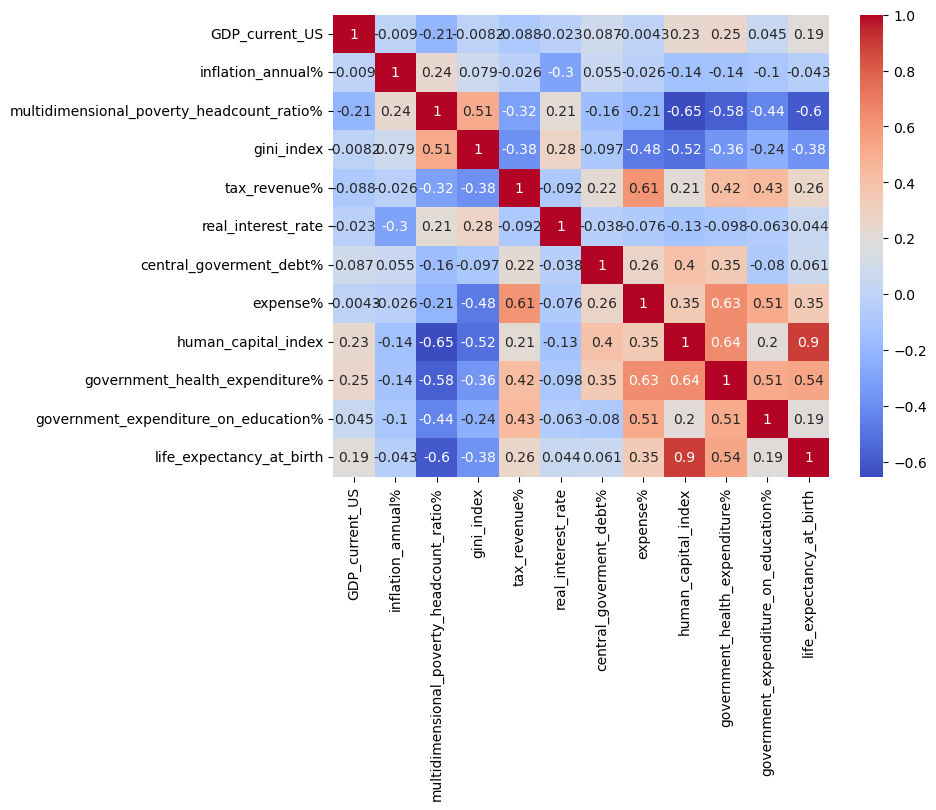

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

## Reaserch Question 1: How strongly is a country’s human capital level associated with its poverty rate (multidimensional poverty headcount ratio)?

Text(0.5, 1.0, 'Human Capital vs Poverty')

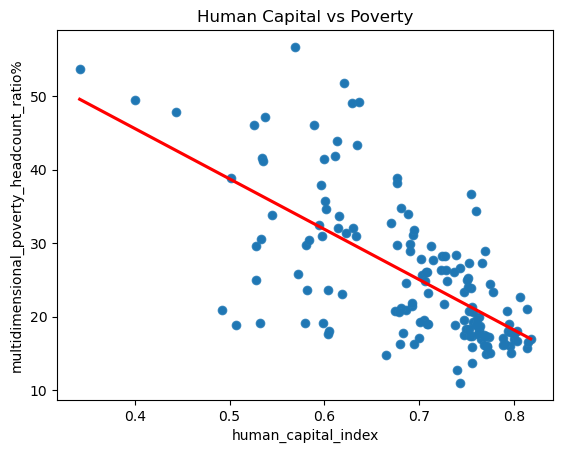

In [21]:
sns.scatterplot(data=df, x="human_capital_index", y="multidimensional_poverty_headcount_ratio%")
sns.regplot(data=df, x="human_capital_index", y="multidimensional_poverty_headcount_ratio%", ci=None, line_kws={"color": "red"})
plt.title(f'Human Capital vs Poverty')

##### This is  Negative corraltion(Spearman r ≈ -0.64)which tells as the human capital index increases, the poverty headcount decreases. It means  the Countries with higher education, skills, and health levels (high human capital) , tend to have much lower poverty rates.

Text(0.5, 1.0, 'distribution of multidimensional_poverty_headcount_ratio')

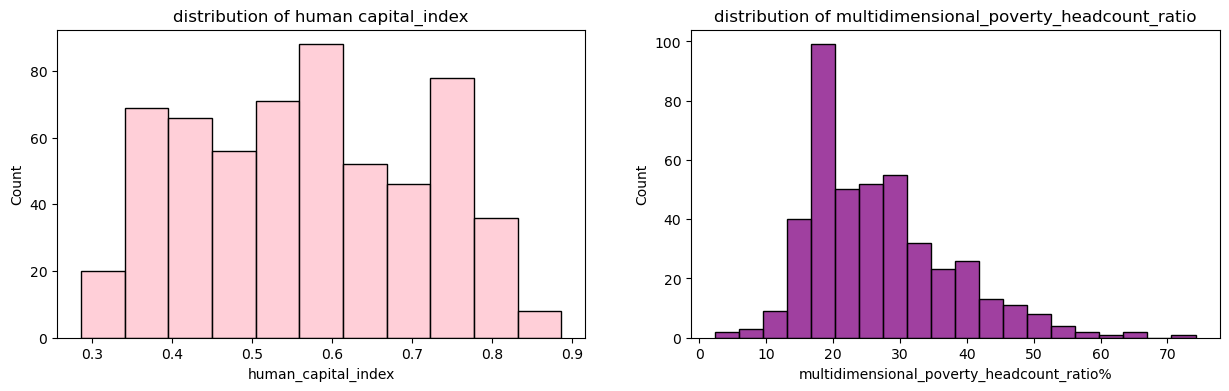

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
colors = ["pink", "purple"]

# Plot 1
sns.histplot(df["human_capital_index"], color=colors[0], ax=axes[0])
axes[0].set_title("distribution of human capital_index")

# Plot 2 (square root)
sns.histplot(df["multidimensional_poverty_headcount_ratio%"], color=colors[1], ax=axes[1])
axes[1].set_title("distribution of multidimensional_poverty_headcount_ratio")

In [23]:
pg.corr(df["human_capital_index"],df["multidimensional_poverty_headcount_ratio%"], method="spearman")

,n,r,CI95%,p-val,power
spearman,148,-0.643364,"[-0.73, -0.54]",1.168146e-18,1.0


In [24]:
df["human_capital_index_log"] = np.log(df["human_capital_index"]+1)
df["multidimensional_poverty_headcount_ratio%_log"] = np.log(df["multidimensional_poverty_headcount_ratio%"]+1)

Text(0.5, 1.0, 'Human Capital vs Poverty (log transformed)')

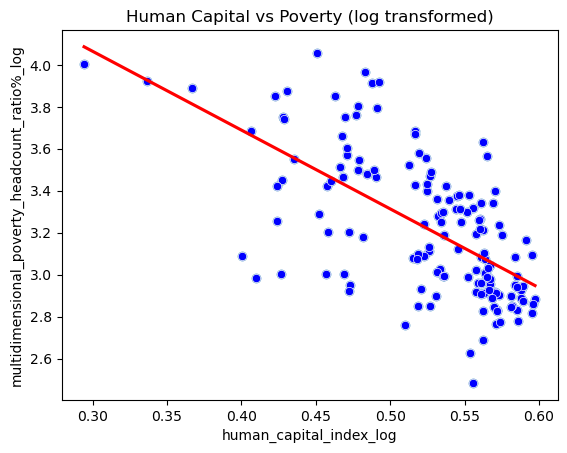

In [25]:
sns.regplot(data=df, x="human_capital_index_log", y="multidimensional_poverty_headcount_ratio%_log", ci=None, line_kws={"color": "red"})
sns.scatterplot(data=df, x="human_capital_index_log", y="multidimensional_poverty_headcount_ratio%_log", color="blue")
plt.title(f'Human Capital vs Poverty (log transformed)')

In [26]:
#without outliers and log transform
pg.corr(df["human_capital_index_log"],df["multidimensional_poverty_headcount_ratio%_log"], method="spearman")

,n,r,CI95%,p-val,power
spearman,148,-0.643364,"[-0.73, -0.54]",1.168146e-18,1.0


##  Reaserch Question 2 'Human Capital vs Life Expectancy at Birth

Text(0.5, 1.0, 'Human Capital vs Life Expectancy at Birth')

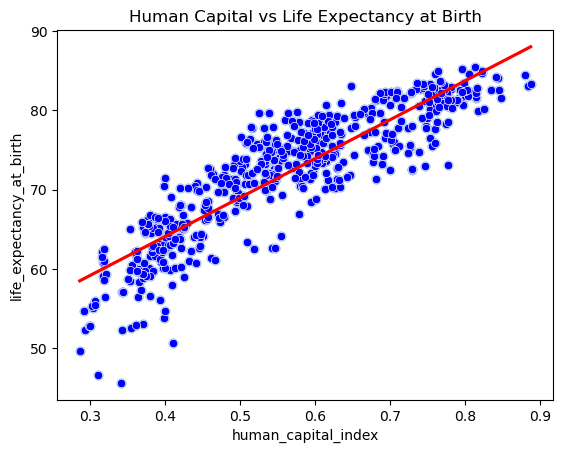

In [27]:
sns.regplot(data=df, x="human_capital_index", y="life_expectancy_at_birth", ci=None, line_kws={"color": "red"})
sns.scatterplot(data=df, x="human_capital_index", y="life_expectancy_at_birth", color="blue")

plt.title(f'Human Capital vs Life Expectancy at Birth')

In [28]:
pg.corr(df["human_capital_index"],df["life_expectancy_at_birth"], method="spearman")

,n,r,CI95%,p-val,power
spearman,584,0.906879,"[0.89, 0.92]",1.343033e-220,1.0


##### The results show a very strong positive correlation (Spearman r ≈ 0.90) between Human Capital Index and Life Expectancy. It means countries with higher HCI (health, education, skills) almost always have higher life expectancy.

##  Reaserch Question 3 'tax revenue  vs expenses 

Text(0.5, 1.0, 'Tax revenue vs Expenses by Government')

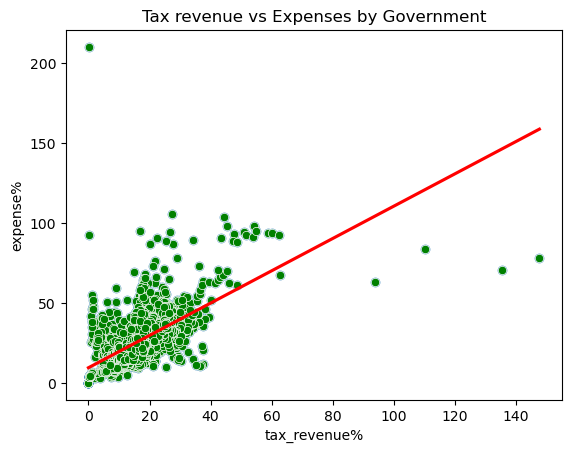

In [29]:
sns.regplot(data=df, x="tax_revenue%", y="expense%", ci=None, line_kws={"color": "red"})
sns.scatterplot(data=df, x="tax_revenue%", y="expense%",color="green")
plt.title(f'Tax revenue vs Expenses by Government')

In [30]:
pg.corr(df["tax_revenue%"],df["expense%"], method="spearman")

,n,r,CI95%,p-val,power
spearman,4014,0.685156,"[0.67, 0.7]",0.0,1.0


##### The results show a moderate positive correlation (Spearman r ≈ 0.68) between Tax Revenue and Government Expenses. It means more tax revenue leads to more government spending.This suggests that countries with higher tax revenue tend to also exhibit higher levels of government spending. The relationship is statistically significant (p < 0.001), and the 95% confidence interval [0.67, 0.70] shows that the correlation is both stable and precise due to the large sample size (n = 4014).